In [4]:
import os
os.chdir('/Users/tobeycarman/Documents/SEL/dvm-dos-tem')

In [9]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import output_utils as ou

In [10]:
PARAM = 'cmax'
PFTNUM = 1
CMTNUM = 4
PXx = 0; PXy = 0
H_RUNFOLDER = '../dvmdostem-workflows/sensitivity_analysis'
D_RUNFOLDER = '/data/workflows/sensitivity_analysis'

samples = np.linspace(start=100, stop=700, num=20)

In [11]:
# Cleanup
!rm -r {H_RUNFOLDER}

# Place to work
!docker compose exec dvmdostem-run setup_working_directory.py \
--input-data-path \
/data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/ \
{D_RUNFOLDER}

# Run mask
!docker compose exec dvmdostem-run runmask-util.py \
--reset --yx {PXy} {PXx} {D_RUNFOLDER}/run-mask.nc

# Outputs
!docker compose exec dvmdostem-run outspec_utils.py \
{D_RUNFOLDER}/config/output_spec.csv --on GPP m p

!docker compose exec dvmdostem-run outspec_utils.py \
{D_RUNFOLDER}/config/output_spec.csv --on CMTNUM y


# Config, enable eq outputs
CONFIG_FILE = H_RUNFOLDER + '/config/config.js'

# Read the existing data into memory
with open(CONFIG_FILE, 'r') as f:
    config = json.load(f)

# Modify it
config['IO']['output_nc_eq'] = 1

# Write it back..
with open(CONFIG_FILE, 'w') as f:
    json.dump(config, f, indent=2)

Namespace(copy_inputs=False, input_data_path='/data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/', new_directory='/data/workflows/sensitivity_analysis', no_cal_targets=False)
Setting all pixels in runmask to '0' (OFF).
Turning pixel(y,x) (0,0) to '1', (ON).
                Name                Units       Yearly      Monthly        Daily          PFT Compartments       Layers    Data Type     Description
                 GPP            g/m2/time            y            m      invalid            p                   invalid       double     GPP
                Name                Units       Yearly      Monthly        Daily          PFT Compartments       Layers    Data Type     Description
              CMTNUM                    m            y      invalid      invalid      invalid      invalid      invalid          int     Community Type Number


In [12]:
def adjust_param(new_value):
    data = !param_util.py --dump-block-to-json {H_RUNFOLDER}/default_parameters/cmt_calparbgc.txt {CMTNUM}

    jdata = json.loads(data[0])

    pft = 'pft{}'.format(PFTNUM)
    jdata[pft][PARAM] = new_value

    with open("tmp_json.json", 'w') as f:
        json.dump(jdata, f)

    new_data = !param_util.py --fmt-block-from-json tmp_json.json {H_RUNFOLDER}/default_parameters/cmt_calparbgc.txt

    with open('{:}/parameters/cmt_calparbgc.txt'.format(H_RUNFOLDER), 'w') as f:
        # make sure to add newlines!
        f.write('\n'.join(new_data))

In [13]:
def run_model():
    !docker compose exec --workdir {D_RUNFOLDER} dvmdostem-run \
    dvmdostem -p 50 -e 200 -s 0 -t 0 -n 0 -l err --force-cmt {CMTNUM}

def collect_outputs():
    # Get the model output
    ds = nc.Dataset('{}/output/GPP_monthly_eq.nc'.format(H_RUNFOLDER))
    gpp = ds.variables['GPP'][:]
    yr_gpp = ou.sum_monthly_flux_to_yearly(gpp)
    output_data = yr_gpp[-1:,PFTNUM,PXy,PXx]

    # Get the parameter value for the run
    paramdata = !param_util.py --dump-block-to-json {H_RUNFOLDER}/parameters/cmt_calparbgc.txt {CMTNUM}
    jparamdata = json.loads(paramdata[0])
    pft = 'pft{}'.format(PFTNUM)
    run_param_value = jparamdata[pft][PARAM]

    with open('{}/sensitivity.csv'.format(H_RUNFOLDER), 'a') as f:
        f.write('{:},{:}\n'.format(run_param_value, output_data[0]))
    

In [14]:
# Backup default params
!cp -r {H_RUNFOLDER}/parameters {H_RUNFOLDER}/default_parameters

# Make a file for storing our sensitivity data
# and put the header in the file.
with open('{}/sensitivity.csv'.format(H_RUNFOLDER), 'w') as f:
  f.write('{:},{:}\n'.format('pvalue','output'))

# Run default case
print("Run default case....")
run_model()
collect_outputs()


for i in samples:
    print("adjust_param({:}) --> run_model() --> collect_outputs()".format(i))
    adjust_param(i)
    run_model()
    collect_outputs()


Run default case....
Setting up logging...
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 5
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 6
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 7
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 8
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 9
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 10
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 11
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 12
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 13
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 14
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 15
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 16
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 17
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 18
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 19
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 20
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 21
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 22
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 23
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 24
[err] [PRE-RUN->Y

[err] [EQ->Y] y: 0 x: 0 Year: 185
[err] [EQ->Y] y: 0 x: 0 Year: 186
[err] [EQ->Y] y: 0 x: 0 Year: 187
[err] [EQ->Y] y: 0 x: 0 Year: 188
[err] [EQ->Y] y: 0 x: 0 Year: 189
[err] [EQ->Y] y: 0 x: 0 Year: 190
[err] [EQ->Y] y: 0 x: 0 Year: 191
[err] [EQ->Y] y: 0 x: 0 Year: 192
[err] [EQ->Y] y: 0 x: 0 Year: 193
[err] [EQ->Y] y: 0 x: 0 Year: 194
[err] [EQ->Y] y: 0 x: 0 Year: 195
[err] [EQ->Y] y: 0 x: 0 Year: 196
[err] [EQ->Y] y: 0 x: 0 Year: 197
[err] [EQ->Y] y: 0 x: 0 Year: 198
[err] [EQ->Y] y: 0 x: 0 Year: 199
cell 0, 0 complete.33
[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping 

[err] [EQ->Y] y: 0 x: 0 Year: 74
[err] [EQ->Y] y: 0 x: 0 Year: 75
[err] [EQ->Y] y: 0 x: 0 Year: 76
[err] [EQ->Y] y: 0 x: 0 Year: 77
[err] [EQ->Y] y: 0 x: 0 Year: 78
[err] [EQ->Y] y: 0 x: 0 Year: 79
[err] [EQ->Y] y: 0 x: 0 Year: 80
[err] [EQ->Y] y: 0 x: 0 Year: 81
[err] [EQ->Y] y: 0 x: 0 Year: 82
[err] [EQ->Y] y: 0 x: 0 Year: 83
[err] [EQ->Y] y: 0 x: 0 Year: 84
[err] [EQ->Y] y: 0 x: 0 Year: 85
[err] [EQ->Y] y: 0 x: 0 Year: 86
[err] [EQ->Y] y: 0 x: 0 Year: 87
[err] [EQ->Y] y: 0 x: 0 Year: 88
[err] [EQ->Y] y: 0 x: 0 Year: 89
[err] [EQ->Y] y: 0 x: 0 Year: 90
[err] [EQ->Y] y: 0 x: 0 Year: 91
[err] [EQ->Y] y: 0 x: 0 Year: 92
[err] [EQ->Y] y: 0 x: 0 Year: 93
[err] [EQ->Y] y: 0 x: 0 Year: 94
[err] [EQ->Y] y: 0 x: 0 Year: 95
[err] [EQ->Y] y: 0 x: 0 Year: 96
[err] [EQ->Y] y: 0 x: 0 Year: 97
[err] [EQ->Y] y: 0 x: 0 Year: 98
[err] [EQ->Y] y: 0 x: 0 Year: 99
[err] [EQ->Y] y: 0 x: 0 Year: 100
[err] [EQ->Y] y: 0 x: 0 Year: 101
[err] [EQ->Y] y: 0 x: 0 Year: 102
[err] [EQ->Y] y: 0 x: 0 Year: 103
[err] 

[err] [PRE-RUN->Y] y: 0 x: 0 Year: 17
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 18
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 19
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 20
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 21
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 22
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 23
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 24
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 25
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 26
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 27
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 28
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 29
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 30
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 31
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 32
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 33
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 34
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 35
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 36
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 37
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 38
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 39
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 40
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 41
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 42
[err] [PRE-R

[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] [] Skipping cell (3, 2)
[fatal] [] Skipping cell (3, 3)
[fatal] [] Skipping cell (3, 4)
[fatal] [] Skipping cell (3, 5)
[fatal] [] Skipping cell (3, 6)
[fatal] [] Skipping cell (3, 7)
[fatal] [] Skipping cell (3, 8)
[fatal] [] Skipping cell (3, 9)
[fatal] [] Skipping cell (4, 0)
[fatal] [] Skipping cell (4, 1)
[fatal] 

[err] [EQ->Y] y: 0 x: 0 Year: 99
[err] [EQ->Y] y: 0 x: 0 Year: 100
[err] [EQ->Y] y: 0 x: 0 Year: 101
[err] [EQ->Y] y: 0 x: 0 Year: 102
[err] [EQ->Y] y: 0 x: 0 Year: 103
[err] [EQ->Y] y: 0 x: 0 Year: 104
[err] [EQ->Y] y: 0 x: 0 Year: 105
[err] [EQ->Y] y: 0 x: 0 Year: 106
[err] [EQ->Y] y: 0 x: 0 Year: 107
[err] [EQ->Y] y: 0 x: 0 Year: 108
[err] [EQ->Y] y: 0 x: 0 Year: 109
[err] [EQ->Y] y: 0 x: 0 Year: 110
[err] [EQ->Y] y: 0 x: 0 Year: 111
[err] [EQ->Y] y: 0 x: 0 Year: 112
[err] [EQ->Y] y: 0 x: 0 Year: 113
[err] [EQ->Y] y: 0 x: 0 Year: 114
[err] [EQ->Y] y: 0 x: 0 Year: 115
[err] [EQ->Y] y: 0 x: 0 Year: 116
[err] [EQ->Y] y: 0 x: 0 Year: 117
[err] [EQ->Y] y: 0 x: 0 Year: 118
[err] [EQ->Y] y: 0 x: 0 Year: 119
[err] [EQ->Y] y: 0 x: 0 Year: 120
[err] [EQ->Y] y: 0 x: 0 Year: 121
[err] [EQ->Y] y: 0 x: 0 Year: 122
[err] [EQ->Y] y: 0 x: 0 Year: 123
[err] [EQ->Y] y: 0 x: 0 Year: 124
[err] [EQ->Y] y: 0 x: 0 Year: 125
[err] [EQ->Y] y: 0 x: 0 Year: 126
[err] [EQ->Y] y: 0 x: 0 Year: 127
[err] [EQ->Y] y

[err] [PRE-RUN->Y] y: 0 x: 0 Year: 39
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 40
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 41
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 42
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 43
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 44
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 45
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 46
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 47
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 48
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 49
[fatal] [EQ] Equilibrium Initial Year Count: 200
[fatal] [EQ] Running Equilibrium, 200 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[err] [EQ->Y] y: 0 x: 0 Year: 5
[err] [EQ->Y] y: 0 x: 0 Year: 6
[err] [EQ->Y] y: 0 x: 0 Year: 7
[err] [EQ->Y] y: 0 x: 0 Year: 8
[err] [EQ->Y] y: 0 x: 0 Year: 9
[err] [EQ->Y] y: 0 x: 0 Year: 10
[err] [EQ->Y] y: 0 x: 0 Year: 11
[err] [EQ->Y] y: 0 x: 0 Year: 12
[err] [EQ->Y] y: 0 x: 0 Year: 13
[err] [EQ->Y] y: 0 x: 0 Year: 14
[er

[fatal] [] Skipping cell (4, 2)
[fatal] [] Skipping cell (4, 3)
[fatal] [] Skipping cell (4, 4)
[fatal] [] Skipping cell (4, 5)
[fatal] [] Skipping cell (4, 6)
[fatal] [] Skipping cell (4, 7)
[fatal] [] Skipping cell (4, 8)
[fatal] [] Skipping cell (4, 9)
[fatal] [] Skipping cell (5, 0)
[fatal] [] Skipping cell (5, 1)
[fatal] [] Skipping cell (5, 2)
[fatal] [] Skipping cell (5, 3)
[fatal] [] Skipping cell (5, 4)
[fatal] [] Skipping cell (5, 5)
[fatal] [] Skipping cell (5, 6)
[fatal] [] Skipping cell (5, 7)
[fatal] [] Skipping cell (5, 8)
[fatal] [] Skipping cell (5, 9)
[fatal] [] Skipping cell (6, 0)
[fatal] [] Skipping cell (6, 1)
[fatal] [] Skipping cell (6, 2)
[fatal] [] Skipping cell (6, 3)
[fatal] [] Skipping cell (6, 4)
[fatal] [] Skipping cell (6, 5)
[fatal] [] Skipping cell (6, 6)
[fatal] [] Skipping cell (6, 7)
[fatal] [] Skipping cell (6, 8)
[fatal] [] Skipping cell (6, 9)
[fatal] [] Skipping cell (7, 0)
[fatal] [] Skipping cell (7, 1)
[fatal] [] Skipping cell (7, 2)
[fatal] 

[err] [EQ->Y] y: 0 x: 0 Year: 128
[err] [EQ->Y] y: 0 x: 0 Year: 129
[err] [EQ->Y] y: 0 x: 0 Year: 130
[err] [EQ->Y] y: 0 x: 0 Year: 131
[err] [EQ->Y] y: 0 x: 0 Year: 132
[err] [EQ->Y] y: 0 x: 0 Year: 133
[err] [EQ->Y] y: 0 x: 0 Year: 134
[err] [EQ->Y] y: 0 x: 0 Year: 135
[err] [EQ->Y] y: 0 x: 0 Year: 136
[err] [EQ->Y] y: 0 x: 0 Year: 137
[err] [EQ->Y] y: 0 x: 0 Year: 138
[err] [EQ->Y] y: 0 x: 0 Year: 139
[err] [EQ->Y] y: 0 x: 0 Year: 140
[err] [EQ->Y] y: 0 x: 0 Year: 141
[err] [EQ->Y] y: 0 x: 0 Year: 142
[err] [EQ->Y] y: 0 x: 0 Year: 143
[err] [EQ->Y] y: 0 x: 0 Year: 144
[err] [EQ->Y] y: 0 x: 0 Year: 145
[err] [EQ->Y] y: 0 x: 0 Year: 146
[err] [EQ->Y] y: 0 x: 0 Year: 147
[err] [EQ->Y] y: 0 x: 0 Year: 148
[err] [EQ->Y] y: 0 x: 0 Year: 149
[err] [EQ->Y] y: 0 x: 0 Year: 150
[err] [EQ->Y] y: 0 x: 0 Year: 151
[err] [EQ->Y] y: 0 x: 0 Year: 152
[err] [EQ->Y] y: 0 x: 0 Year: 153
[err] [EQ->Y] y: 0 x: 0 Year: 154
[err] [EQ->Y] y: 0 x: 0 Year: 155
[err] [EQ->Y] y: 0 x: 0 Year: 156
[err] [EQ->Y] 

[err] [EQ->Y] y: 0 x: 0 Year: 15
[err] [EQ->Y] y: 0 x: 0 Year: 16
[err] [EQ->Y] y: 0 x: 0 Year: 17
[err] [EQ->Y] y: 0 x: 0 Year: 18
[err] [EQ->Y] y: 0 x: 0 Year: 19
[err] [EQ->Y] y: 0 x: 0 Year: 20
[err] [EQ->Y] y: 0 x: 0 Year: 21
[err] [EQ->Y] y: 0 x: 0 Year: 22
[err] [EQ->Y] y: 0 x: 0 Year: 23
[err] [EQ->Y] y: 0 x: 0 Year: 24
[err] [EQ->Y] y: 0 x: 0 Year: 25
[err] [EQ->Y] y: 0 x: 0 Year: 26
[err] [EQ->Y] y: 0 x: 0 Year: 27
[err] [EQ->Y] y: 0 x: 0 Year: 28
[err] [EQ->Y] y: 0 x: 0 Year: 29
[err] [EQ->Y] y: 0 x: 0 Year: 30
[err] [EQ->Y] y: 0 x: 0 Year: 31
[err] [EQ->Y] y: 0 x: 0 Year: 32
[err] [EQ->Y] y: 0 x: 0 Year: 33
[err] [EQ->Y] y: 0 x: 0 Year: 34
[err] [EQ->Y] y: 0 x: 0 Year: 35
[err] [EQ->Y] y: 0 x: 0 Year: 36
[err] [EQ->Y] y: 0 x: 0 Year: 37
[err] [EQ->Y] y: 0 x: 0 Year: 38
[err] [EQ->Y] y: 0 x: 0 Year: 39
[err] [EQ->Y] y: 0 x: 0 Year: 40
[err] [EQ->Y] y: 0 x: 0 Year: 41
[err] [EQ->Y] y: 0 x: 0 Year: 42
[err] [EQ->Y] y: 0 x: 0 Year: 43
[err] [EQ->Y] y: 0 x: 0 Year: 44
[err] [EQ-

[fatal] [] Skipping cell (6, 8)
[fatal] [] Skipping cell (6, 9)
[fatal] [] Skipping cell (7, 0)
[fatal] [] Skipping cell (7, 1)
[fatal] [] Skipping cell (7, 2)
[fatal] [] Skipping cell (7, 3)
[fatal] [] Skipping cell (7, 4)
[fatal] [] Skipping cell (7, 5)
[fatal] [] Skipping cell (7, 6)
[fatal] [] Skipping cell (7, 7)
[fatal] [] Skipping cell (7, 8)
[fatal] [] Skipping cell (7, 9)
[fatal] [] Skipping cell (8, 0)
[fatal] [] Skipping cell (8, 1)
[fatal] [] Skipping cell (8, 2)
[fatal] [] Skipping cell (8, 3)
[fatal] [] Skipping cell (8, 4)
[fatal] [] Skipping cell (8, 5)
[fatal] [] Skipping cell (8, 6)
[fatal] [] Skipping cell (8, 7)
[fatal] [] Skipping cell (8, 8)
[fatal] [] Skipping cell (8, 9)
[fatal] [] Skipping cell (9, 0)
[fatal] [] Skipping cell (9, 1)
[fatal] [] Skipping cell (9, 2)
[fatal] [] Skipping cell (9, 3)
[fatal] [] Skipping cell (9, 4)
[fatal] [] Skipping cell (9, 5)
[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] 

[err] [EQ->Y] y: 0 x: 0 Year: 153
[err] [EQ->Y] y: 0 x: 0 Year: 154
[err] [EQ->Y] y: 0 x: 0 Year: 155
[err] [EQ->Y] y: 0 x: 0 Year: 156
[err] [EQ->Y] y: 0 x: 0 Year: 157
[err] [EQ->Y] y: 0 x: 0 Year: 158
[err] [EQ->Y] y: 0 x: 0 Year: 159
[err] [EQ->Y] y: 0 x: 0 Year: 160
[err] [EQ->Y] y: 0 x: 0 Year: 161
[err] [EQ->Y] y: 0 x: 0 Year: 162
[err] [EQ->Y] y: 0 x: 0 Year: 163
[err] [EQ->Y] y: 0 x: 0 Year: 164
[err] [EQ->Y] y: 0 x: 0 Year: 165
[err] [EQ->Y] y: 0 x: 0 Year: 166
[err] [EQ->Y] y: 0 x: 0 Year: 167
[err] [EQ->Y] y: 0 x: 0 Year: 168
[err] [EQ->Y] y: 0 x: 0 Year: 169
[err] [EQ->Y] y: 0 x: 0 Year: 170
[err] [EQ->Y] y: 0 x: 0 Year: 171
[err] [EQ->Y] y: 0 x: 0 Year: 172
[err] [EQ->Y] y: 0 x: 0 Year: 173
[err] [EQ->Y] y: 0 x: 0 Year: 174
[err] [EQ->Y] y: 0 x: 0 Year: 175
[err] [EQ->Y] y: 0 x: 0 Year: 176
[err] [EQ->Y] y: 0 x: 0 Year: 177
[err] [EQ->Y] y: 0 x: 0 Year: 178
[err] [EQ->Y] y: 0 x: 0 Year: 179
[err] [EQ->Y] y: 0 x: 0 Year: 180
[err] [EQ->Y] y: 0 x: 0 Year: 181
[err] [EQ->Y] 

[err] [EQ->Y] y: 0 x: 0 Year: 41
[err] [EQ->Y] y: 0 x: 0 Year: 42
[err] [EQ->Y] y: 0 x: 0 Year: 43
[err] [EQ->Y] y: 0 x: 0 Year: 44
[err] [EQ->Y] y: 0 x: 0 Year: 45
[err] [EQ->Y] y: 0 x: 0 Year: 46
[err] [EQ->Y] y: 0 x: 0 Year: 47
[err] [EQ->Y] y: 0 x: 0 Year: 48
[err] [EQ->Y] y: 0 x: 0 Year: 49
[err] [EQ->Y] y: 0 x: 0 Year: 50
[err] [EQ->Y] y: 0 x: 0 Year: 51
[err] [EQ->Y] y: 0 x: 0 Year: 52
[err] [EQ->Y] y: 0 x: 0 Year: 53
[err] [EQ->Y] y: 0 x: 0 Year: 54
[err] [EQ->Y] y: 0 x: 0 Year: 55
[err] [EQ->Y] y: 0 x: 0 Year: 56
[err] [EQ->Y] y: 0 x: 0 Year: 57
[err] [EQ->Y] y: 0 x: 0 Year: 58
[err] [EQ->Y] y: 0 x: 0 Year: 59
[err] [EQ->Y] y: 0 x: 0 Year: 60
[err] [EQ->Y] y: 0 x: 0 Year: 61
[err] [EQ->Y] y: 0 x: 0 Year: 62
[err] [EQ->Y] y: 0 x: 0 Year: 63
[err] [EQ->Y] y: 0 x: 0 Year: 64
[err] [EQ->Y] y: 0 x: 0 Year: 65
[err] [EQ->Y] y: 0 x: 0 Year: 66
[err] [EQ->Y] y: 0 x: 0 Year: 67
[err] [EQ->Y] y: 0 x: 0 Year: 68
[err] [EQ->Y] y: 0 x: 0 Year: 69
[err] [EQ->Y] y: 0 x: 0 Year: 70
[err] [EQ-

[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)
Total Seconds: 32
adjust_param(352.63157894736844) --> run_model() --> collect_outputs()
Setting up logging...
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 5
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 6
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 7
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 8
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 9
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 10
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 11
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 12
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 13
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 14
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 15
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 16
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 17
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 18
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 19
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 20
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 21

[err] [EQ->Y] y: 0 x: 0 Year: 181
[err] [EQ->Y] y: 0 x: 0 Year: 182
[err] [EQ->Y] y: 0 x: 0 Year: 183
[err] [EQ->Y] y: 0 x: 0 Year: 184
[err] [EQ->Y] y: 0 x: 0 Year: 185
[err] [EQ->Y] y: 0 x: 0 Year: 186
[err] [EQ->Y] y: 0 x: 0 Year: 187
[err] [EQ->Y] y: 0 x: 0 Year: 188
[err] [EQ->Y] y: 0 x: 0 Year: 189
[err] [EQ->Y] y: 0 x: 0 Year: 190
[err] [EQ->Y] y: 0 x: 0 Year: 191
[err] [EQ->Y] y: 0 x: 0 Year: 192
[err] [EQ->Y] y: 0 x: 0 Year: 193
[err] [EQ->Y] y: 0 x: 0 Year: 194
[err] [EQ->Y] y: 0 x: 0 Year: 195
[err] [EQ->Y] y: 0 x: 0 Year: 196
[err] [EQ->Y] y: 0 x: 0 Year: 197
[err] [EQ->Y] y: 0 x: 0 Year: 198
[err] [EQ->Y] y: 0 x: 0 Year: 199
cell 0, 0 complete.32
[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] S

[err] [EQ->Y] y: 0 x: 0 Year: 69
[err] [EQ->Y] y: 0 x: 0 Year: 70
[err] [EQ->Y] y: 0 x: 0 Year: 71
[err] [EQ->Y] y: 0 x: 0 Year: 72
[err] [EQ->Y] y: 0 x: 0 Year: 73
[err] [EQ->Y] y: 0 x: 0 Year: 74
[err] [EQ->Y] y: 0 x: 0 Year: 75
[err] [EQ->Y] y: 0 x: 0 Year: 76
[err] [EQ->Y] y: 0 x: 0 Year: 77
[err] [EQ->Y] y: 0 x: 0 Year: 78
[err] [EQ->Y] y: 0 x: 0 Year: 79
[err] [EQ->Y] y: 0 x: 0 Year: 80
[err] [EQ->Y] y: 0 x: 0 Year: 81
[err] [EQ->Y] y: 0 x: 0 Year: 82
[err] [EQ->Y] y: 0 x: 0 Year: 83
[err] [EQ->Y] y: 0 x: 0 Year: 84
[err] [EQ->Y] y: 0 x: 0 Year: 85
[err] [EQ->Y] y: 0 x: 0 Year: 86
[err] [EQ->Y] y: 0 x: 0 Year: 87
[err] [EQ->Y] y: 0 x: 0 Year: 88
[err] [EQ->Y] y: 0 x: 0 Year: 89
[err] [EQ->Y] y: 0 x: 0 Year: 90
[err] [EQ->Y] y: 0 x: 0 Year: 91
[err] [EQ->Y] y: 0 x: 0 Year: 92
[err] [EQ->Y] y: 0 x: 0 Year: 93
[err] [EQ->Y] y: 0 x: 0 Year: 94
[err] [EQ->Y] y: 0 x: 0 Year: 95
[err] [EQ->Y] y: 0 x: 0 Year: 96
[err] [EQ->Y] y: 0 x: 0 Year: 97
[err] [EQ->Y] y: 0 x: 0 Year: 98
[err] [EQ-

[err] [PRE-RUN->Y] y: 0 x: 0 Year: 13
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 14
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 15
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 16
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 17
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 18
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 19
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 20
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 21
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 22
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 23
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 24
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 25
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 26
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 27
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 28
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 29
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 30
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 31
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 32
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 33
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 34
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 35
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 36
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 37
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 38
[err] [PRE-R

[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] [] Skipping cell (3, 2)
[fatal] [] Skipping cell (3, 3)
[fatal] 

[err] [EQ->Y] y: 0 x: 0 Year: 92
[err] [EQ->Y] y: 0 x: 0 Year: 93
[err] [EQ->Y] y: 0 x: 0 Year: 94
[err] [EQ->Y] y: 0 x: 0 Year: 95
[err] [EQ->Y] y: 0 x: 0 Year: 96
[err] [EQ->Y] y: 0 x: 0 Year: 97
[err] [EQ->Y] y: 0 x: 0 Year: 98
[err] [EQ->Y] y: 0 x: 0 Year: 99
[err] [EQ->Y] y: 0 x: 0 Year: 100
[err] [EQ->Y] y: 0 x: 0 Year: 101
[err] [EQ->Y] y: 0 x: 0 Year: 102
[err] [EQ->Y] y: 0 x: 0 Year: 103
[err] [EQ->Y] y: 0 x: 0 Year: 104
[err] [EQ->Y] y: 0 x: 0 Year: 105
[err] [EQ->Y] y: 0 x: 0 Year: 106
[err] [EQ->Y] y: 0 x: 0 Year: 107
[err] [EQ->Y] y: 0 x: 0 Year: 108
[err] [EQ->Y] y: 0 x: 0 Year: 109
[err] [EQ->Y] y: 0 x: 0 Year: 110
[err] [EQ->Y] y: 0 x: 0 Year: 111
[err] [EQ->Y] y: 0 x: 0 Year: 112
[err] [EQ->Y] y: 0 x: 0 Year: 113
[err] [EQ->Y] y: 0 x: 0 Year: 114
[err] [EQ->Y] y: 0 x: 0 Year: 115
[err] [EQ->Y] y: 0 x: 0 Year: 116
[err] [EQ->Y] y: 0 x: 0 Year: 117
[err] [EQ->Y] y: 0 x: 0 Year: 118
[err] [EQ->Y] y: 0 x: 0 Year: 119
[err] [EQ->Y] y: 0 x: 0 Year: 120
[err] [EQ->Y] y: 0 x: 

[err] [PRE-RUN->Y] y: 0 x: 0 Year: 33
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 34
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 35
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 36
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 37
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 38
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 39
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 40
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 41
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 42
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 43
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 44
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 45
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 46
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 47
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 48
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 49
[fatal] [EQ] Equilibrium Initial Year Count: 200
[fatal] [EQ] Running Equilibrium, 200 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[err] [EQ->Y] y: 0 x: 0 Year: 5
[err] [EQ->Y] y: 0 x: 0 Year: 6
[err] [EQ->Y] y: 0 x: 0 Year: 7
[err

[fatal] [] Skipping cell (3, 5)
[fatal] [] Skipping cell (3, 6)
[fatal] [] Skipping cell (3, 7)
[fatal] [] Skipping cell (3, 8)
[fatal] [] Skipping cell (3, 9)
[fatal] [] Skipping cell (4, 0)
[fatal] [] Skipping cell (4, 1)
[fatal] [] Skipping cell (4, 2)
[fatal] [] Skipping cell (4, 3)
[fatal] [] Skipping cell (4, 4)
[fatal] [] Skipping cell (4, 5)
[fatal] [] Skipping cell (4, 6)
[fatal] [] Skipping cell (4, 7)
[fatal] [] Skipping cell (4, 8)
[fatal] [] Skipping cell (4, 9)
[fatal] [] Skipping cell (5, 0)
[fatal] [] Skipping cell (5, 1)
[fatal] [] Skipping cell (5, 2)
[fatal] [] Skipping cell (5, 3)
[fatal] [] Skipping cell (5, 4)
[fatal] [] Skipping cell (5, 5)
[fatal] [] Skipping cell (5, 6)
[fatal] [] Skipping cell (5, 7)
[fatal] [] Skipping cell (5, 8)
[fatal] [] Skipping cell (5, 9)
[fatal] [] Skipping cell (6, 0)
[fatal] [] Skipping cell (6, 1)
[fatal] [] Skipping cell (6, 2)
[fatal] [] Skipping cell (6, 3)
[fatal] [] Skipping cell (6, 4)
[fatal] [] Skipping cell (6, 5)
[fatal] 

[err] [EQ->Y] y: 0 x: 0 Year: 122
[err] [EQ->Y] y: 0 x: 0 Year: 123
[err] [EQ->Y] y: 0 x: 0 Year: 124
[err] [EQ->Y] y: 0 x: 0 Year: 125
[err] [EQ->Y] y: 0 x: 0 Year: 126
[err] [EQ->Y] y: 0 x: 0 Year: 127
[err] [EQ->Y] y: 0 x: 0 Year: 128
[err] [EQ->Y] y: 0 x: 0 Year: 129
[err] [EQ->Y] y: 0 x: 0 Year: 130
[err] [EQ->Y] y: 0 x: 0 Year: 131
[err] [EQ->Y] y: 0 x: 0 Year: 132
[err] [EQ->Y] y: 0 x: 0 Year: 133
[err] [EQ->Y] y: 0 x: 0 Year: 134
[err] [EQ->Y] y: 0 x: 0 Year: 135
[err] [EQ->Y] y: 0 x: 0 Year: 136
[err] [EQ->Y] y: 0 x: 0 Year: 137
[err] [EQ->Y] y: 0 x: 0 Year: 138
[err] [EQ->Y] y: 0 x: 0 Year: 139
[err] [EQ->Y] y: 0 x: 0 Year: 140
[err] [EQ->Y] y: 0 x: 0 Year: 141
[err] [EQ->Y] y: 0 x: 0 Year: 142
[err] [EQ->Y] y: 0 x: 0 Year: 143
[err] [EQ->Y] y: 0 x: 0 Year: 144
[err] [EQ->Y] y: 0 x: 0 Year: 145
[err] [EQ->Y] y: 0 x: 0 Year: 146
[err] [EQ->Y] y: 0 x: 0 Year: 147
[err] [EQ->Y] y: 0 x: 0 Year: 148
[err] [EQ->Y] y: 0 x: 0 Year: 149
[err] [EQ->Y] y: 0 x: 0 Year: 150
[err] [EQ->Y] 

[err] [EQ->Y] y: 0 x: 0 Year: 9
[err] [EQ->Y] y: 0 x: 0 Year: 10
[err] [EQ->Y] y: 0 x: 0 Year: 11
[err] [EQ->Y] y: 0 x: 0 Year: 12
[err] [EQ->Y] y: 0 x: 0 Year: 13
[err] [EQ->Y] y: 0 x: 0 Year: 14
[err] [EQ->Y] y: 0 x: 0 Year: 15
[err] [EQ->Y] y: 0 x: 0 Year: 16
[err] [EQ->Y] y: 0 x: 0 Year: 17
[err] [EQ->Y] y: 0 x: 0 Year: 18
[err] [EQ->Y] y: 0 x: 0 Year: 19
[err] [EQ->Y] y: 0 x: 0 Year: 20
[err] [EQ->Y] y: 0 x: 0 Year: 21
[err] [EQ->Y] y: 0 x: 0 Year: 22
[err] [EQ->Y] y: 0 x: 0 Year: 23
[err] [EQ->Y] y: 0 x: 0 Year: 24
[err] [EQ->Y] y: 0 x: 0 Year: 25
[err] [EQ->Y] y: 0 x: 0 Year: 26
[err] [EQ->Y] y: 0 x: 0 Year: 27
[err] [EQ->Y] y: 0 x: 0 Year: 28
[err] [EQ->Y] y: 0 x: 0 Year: 29
[err] [EQ->Y] y: 0 x: 0 Year: 30
[err] [EQ->Y] y: 0 x: 0 Year: 31
[err] [EQ->Y] y: 0 x: 0 Year: 32
[err] [EQ->Y] y: 0 x: 0 Year: 33
[err] [EQ->Y] y: 0 x: 0 Year: 34
[err] [EQ->Y] y: 0 x: 0 Year: 35
[err] [EQ->Y] y: 0 x: 0 Year: 36
[err] [EQ->Y] y: 0 x: 0 Year: 37
[err] [EQ->Y] y: 0 x: 0 Year: 38
[err] [EQ->

[fatal] [] Skipping cell (6, 3)
[fatal] [] Skipping cell (6, 4)
[fatal] [] Skipping cell (6, 5)
[fatal] [] Skipping cell (6, 6)
[fatal] [] Skipping cell (6, 7)
[fatal] [] Skipping cell (6, 8)
[fatal] [] Skipping cell (6, 9)
[fatal] [] Skipping cell (7, 0)
[fatal] [] Skipping cell (7, 1)
[fatal] [] Skipping cell (7, 2)
[fatal] [] Skipping cell (7, 3)
[fatal] [] Skipping cell (7, 4)
[fatal] [] Skipping cell (7, 5)
[fatal] [] Skipping cell (7, 6)
[fatal] [] Skipping cell (7, 7)
[fatal] [] Skipping cell (7, 8)
[fatal] [] Skipping cell (7, 9)
[fatal] [] Skipping cell (8, 0)
[fatal] [] Skipping cell (8, 1)
[fatal] [] Skipping cell (8, 2)
[fatal] [] Skipping cell (8, 3)
[fatal] [] Skipping cell (8, 4)
[fatal] [] Skipping cell (8, 5)
[fatal] [] Skipping cell (8, 6)
[fatal] [] Skipping cell (8, 7)
[fatal] [] Skipping cell (8, 8)
[fatal] [] Skipping cell (8, 9)
[fatal] [] Skipping cell (9, 0)
[fatal] [] Skipping cell (9, 1)
[fatal] [] Skipping cell (9, 2)
[fatal] [] Skipping cell (9, 3)
[fatal] 

[err] [EQ->Y] y: 0 x: 0 Year: 148
[err] [EQ->Y] y: 0 x: 0 Year: 149
[err] [EQ->Y] y: 0 x: 0 Year: 150
[err] [EQ->Y] y: 0 x: 0 Year: 151
[err] [EQ->Y] y: 0 x: 0 Year: 152
[err] [EQ->Y] y: 0 x: 0 Year: 153
[err] [EQ->Y] y: 0 x: 0 Year: 154
[err] [EQ->Y] y: 0 x: 0 Year: 155
[err] [EQ->Y] y: 0 x: 0 Year: 156
[err] [EQ->Y] y: 0 x: 0 Year: 157
[err] [EQ->Y] y: 0 x: 0 Year: 158
[err] [EQ->Y] y: 0 x: 0 Year: 159
[err] [EQ->Y] y: 0 x: 0 Year: 160
[err] [EQ->Y] y: 0 x: 0 Year: 161
[err] [EQ->Y] y: 0 x: 0 Year: 162
[err] [EQ->Y] y: 0 x: 0 Year: 163
[err] [EQ->Y] y: 0 x: 0 Year: 164
[err] [EQ->Y] y: 0 x: 0 Year: 165
[err] [EQ->Y] y: 0 x: 0 Year: 166
[err] [EQ->Y] y: 0 x: 0 Year: 167
[err] [EQ->Y] y: 0 x: 0 Year: 168
[err] [EQ->Y] y: 0 x: 0 Year: 169
[err] [EQ->Y] y: 0 x: 0 Year: 170
[err] [EQ->Y] y: 0 x: 0 Year: 171
[err] [EQ->Y] y: 0 x: 0 Year: 172
[err] [EQ->Y] y: 0 x: 0 Year: 173
[err] [EQ->Y] y: 0 x: 0 Year: 174
[err] [EQ->Y] y: 0 x: 0 Year: 175
[err] [EQ->Y] y: 0 x: 0 Year: 176
[err] [EQ->Y] 

[err] [EQ->Y] y: 0 x: 0 Year: 35
[err] [EQ->Y] y: 0 x: 0 Year: 36
[err] [EQ->Y] y: 0 x: 0 Year: 37
[err] [EQ->Y] y: 0 x: 0 Year: 38
[err] [EQ->Y] y: 0 x: 0 Year: 39
[err] [EQ->Y] y: 0 x: 0 Year: 40
[err] [EQ->Y] y: 0 x: 0 Year: 41
[err] [EQ->Y] y: 0 x: 0 Year: 42
[err] [EQ->Y] y: 0 x: 0 Year: 43
[err] [EQ->Y] y: 0 x: 0 Year: 44
[err] [EQ->Y] y: 0 x: 0 Year: 45
[err] [EQ->Y] y: 0 x: 0 Year: 46
[err] [EQ->Y] y: 0 x: 0 Year: 47
[err] [EQ->Y] y: 0 x: 0 Year: 48
[err] [EQ->Y] y: 0 x: 0 Year: 49
[err] [EQ->Y] y: 0 x: 0 Year: 50
[err] [EQ->Y] y: 0 x: 0 Year: 51
[err] [EQ->Y] y: 0 x: 0 Year: 52
[err] [EQ->Y] y: 0 x: 0 Year: 53
[err] [EQ->Y] y: 0 x: 0 Year: 54
[err] [EQ->Y] y: 0 x: 0 Year: 55
[err] [EQ->Y] y: 0 x: 0 Year: 56
[err] [EQ->Y] y: 0 x: 0 Year: 57
[err] [EQ->Y] y: 0 x: 0 Year: 58
[err] [EQ->Y] y: 0 x: 0 Year: 59
[err] [EQ->Y] y: 0 x: 0 Year: 60
[err] [EQ->Y] y: 0 x: 0 Year: 61
[err] [EQ->Y] y: 0 x: 0 Year: 62
[err] [EQ->Y] y: 0 x: 0 Year: 63
[err] [EQ->Y] y: 0 x: 0 Year: 64
[err] [EQ-

[fatal] [] Skipping cell (9, 4)
[fatal] [] Skipping cell (9, 5)
[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)
Total Seconds: 33
adjust_param(636.8421052631579) --> run_model() --> collect_outputs()
Setting up logging...
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 5
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 6
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 7
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 8
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 9
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 10
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 11
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 12
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 13
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 14
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 15
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 16
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 17
[err] [PRE-RUN->Y] y: 0 

[err] [EQ->Y] y: 0 x: 0 Year: 177
[err] [EQ->Y] y: 0 x: 0 Year: 178
[err] [EQ->Y] y: 0 x: 0 Year: 179
[err] [EQ->Y] y: 0 x: 0 Year: 180
[err] [EQ->Y] y: 0 x: 0 Year: 181
[err] [EQ->Y] y: 0 x: 0 Year: 182
[err] [EQ->Y] y: 0 x: 0 Year: 183
[err] [EQ->Y] y: 0 x: 0 Year: 184
[err] [EQ->Y] y: 0 x: 0 Year: 185
[err] [EQ->Y] y: 0 x: 0 Year: 186
[err] [EQ->Y] y: 0 x: 0 Year: 187
[err] [EQ->Y] y: 0 x: 0 Year: 188
[err] [EQ->Y] y: 0 x: 0 Year: 189
[err] [EQ->Y] y: 0 x: 0 Year: 190
[err] [EQ->Y] y: 0 x: 0 Year: 191
[err] [EQ->Y] y: 0 x: 0 Year: 192
[err] [EQ->Y] y: 0 x: 0 Year: 193
[err] [EQ->Y] y: 0 x: 0 Year: 194
[err] [EQ->Y] y: 0 x: 0 Year: 195
[err] [EQ->Y] y: 0 x: 0 Year: 196
[err] [EQ->Y] y: 0 x: 0 Year: 197
[err] [EQ->Y] y: 0 x: 0 Year: 198
[err] [EQ->Y] y: 0 x: 0 Year: 199
cell 0, 0 complete.33
[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fat

[err] [EQ->Y] y: 0 x: 0 Year: 65
[err] [EQ->Y] y: 0 x: 0 Year: 66
[err] [EQ->Y] y: 0 x: 0 Year: 67
[err] [EQ->Y] y: 0 x: 0 Year: 68
[err] [EQ->Y] y: 0 x: 0 Year: 69
[err] [EQ->Y] y: 0 x: 0 Year: 70
[err] [EQ->Y] y: 0 x: 0 Year: 71
[err] [EQ->Y] y: 0 x: 0 Year: 72
[err] [EQ->Y] y: 0 x: 0 Year: 73
[err] [EQ->Y] y: 0 x: 0 Year: 74
[err] [EQ->Y] y: 0 x: 0 Year: 75
[err] [EQ->Y] y: 0 x: 0 Year: 76
[err] [EQ->Y] y: 0 x: 0 Year: 77
[err] [EQ->Y] y: 0 x: 0 Year: 78
[err] [EQ->Y] y: 0 x: 0 Year: 79
[err] [EQ->Y] y: 0 x: 0 Year: 80
[err] [EQ->Y] y: 0 x: 0 Year: 81
[err] [EQ->Y] y: 0 x: 0 Year: 82
[err] [EQ->Y] y: 0 x: 0 Year: 83
[err] [EQ->Y] y: 0 x: 0 Year: 84
[err] [EQ->Y] y: 0 x: 0 Year: 85
[err] [EQ->Y] y: 0 x: 0 Year: 86
[err] [EQ->Y] y: 0 x: 0 Year: 87
[err] [EQ->Y] y: 0 x: 0 Year: 88
[err] [EQ->Y] y: 0 x: 0 Year: 89
[err] [EQ->Y] y: 0 x: 0 Year: 90
[err] [EQ->Y] y: 0 x: 0 Year: 91
[err] [EQ->Y] y: 0 x: 0 Year: 92
[err] [EQ->Y] y: 0 x: 0 Year: 93
[err] [EQ->Y] y: 0 x: 0 Year: 94
[err] [EQ-

[err] [PRE-RUN->Y] y: 0 x: 0 Year: 10
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 11
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 12
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 13
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 14
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 15
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 16
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 17
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 18
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 19
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 20
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 21
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 22
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 23
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 24
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 25
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 26
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 27
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 28
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 29
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 30
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 31
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 32
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 33
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 34
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 35
[err] [PRE-R

[err] [EQ->Y] y: 0 x: 0 Year: 197
[err] [EQ->Y] y: 0 x: 0 Year: 198
[err] [EQ->Y] y: 0 x: 0 Year: 199
cell 0, 0 complete.33
[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] S

In [15]:
df = pd.read_csv('{:}/sensitivity.csv'.format(H_RUNFOLDER))



In [16]:
sens_df = pd.DataFrame(dict(pvalue=df.pvalue[1:], sensitivity=(df.output[0] - df.output[1:])/abs(df.output[0])))

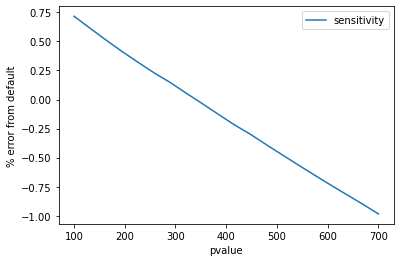

In [30]:
axes = sens_df.plot('pvalue', 'sensitivity', kind='line', ylabel='% error from default')
#axes = plt.plot(sens_df.pvalue, sens_df.sensitivity)



In [29]:
type(ax)


list

In [314]:
df

,pvalue,output
0,340.000000,170.530186
1,100.000000,48.272444
2,110.526316,53.989206
3,121.052632,59.746019
4,131.578947,65.923182
5,142.105263,71.501642
6,152.631579,77.354641
7,163.157895,83.264053
8,173.684211,88.675945
9,184.210526,94.534330


In [312]:
!cat {H_RUNFOLDER}/sensitivity.csv

pvalue,output
340.0,170.5301856994629
100.0,48.27244377136607
110.526316,53.98920631409073
121.052632,59.74601864815152
131.578947,65.92318177223613
142.105263,71.50164151192133
152.631579,77.35464143753482
163.157895,83.26405334251467
173.684211,88.67594522237778
184.210526,94.53433046489954
194.736842,100.0493536889553
205.263158,105.17590796947479
215.789474,110.70520439743996
226.315789,115.93896755576134
236.842105,121.25304067134857
247.368421,126.48794168233871
257.894737,131.3926938176155
268.421053,135.46953547000885
278.947368,140.46381241083145
289.473684,145.43372577428818
300.0,150.85528206825256
